# Module 3 Practice Assessment - Mission Planning
**This is an ungraded practice assignment**. In this notebook, you will be given an opportunity to implement Dijkstra's search algorithm on a road network in Berkeley, California. You will then modify that algorithm using a distance heuristic to perform A* search. You will then get a chance to compare your shortest path to the mapping library's path. If they match, congratulations! 

**In this notebook, you will:**
* Implement Dijkstra's search algorithm on a road network graph.
* Implement the A* search algorithm using a Euclidean heuristic on a road network graph. 

For most exercises, you are provided with a suggested outline. You are encouraged to diverge from the outline if you think there is a better, more efficient way to solve a problem.
Launch the Jupyter Notebook to begin!
We recommend that you refer to the solution only after you finish this practice exercise.

This practice assessment will give you a chance to cement your knowledge that you gained through the Module 3 videos by giving you hands-on experience using real map data. In this assessment, we will be relying on the [OSMNX library](https://osmnx.readthedocs.io/en/stable/) to generate Python graphs from Open Street Map (OSM) data. These graphs will be represented using the [NetworkX library](https://networkx.github.io/documentation/stable/). Both of these links are to the documentation, which you will find useful in this assessment.

In [1]:
import osmnx as ox
import networkx as nx
import queue
import math
import priority_dict

For this assessment, we're going to be focusing on planning in Berkeley, California, between the two nodes given below. After running the code up to and includeing the box below, you should see the output of the shortest path between the two points. Your goal is to get the same output yourself when you implement Dijkstra's and A*.

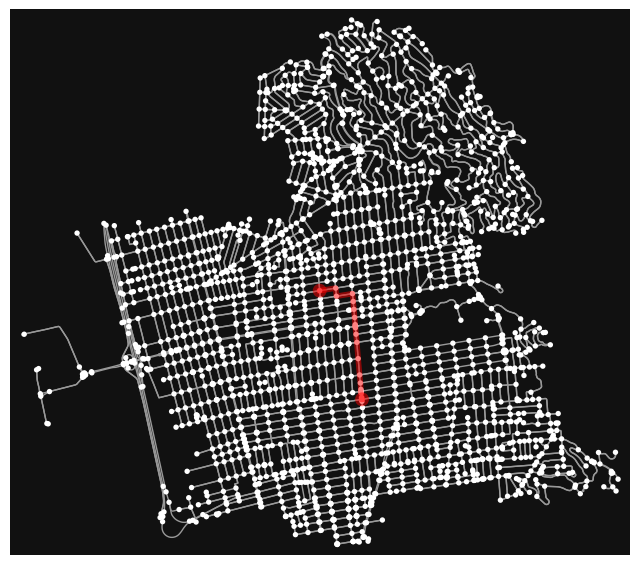

In [2]:
map_graph = ox.graph_from_place('Berkeley, California', network_type='drive')
origin = ox.nearest_nodes(map_graph, -122.277, 37.8743)
destination = list(map_graph.nodes())[-6]
shortest_path = nx.shortest_path(map_graph, origin, destination, weight='length')
fig, ax = ox.plot_graph_route(map_graph, shortest_path)

## Dijkstra's Search
First, let's focus on Dijkstra's algorithm. As a refresher, we've included the pseudocode from the Module 3 lessons below.

![Dijkstra's Pseudocode](dijkstra.png)

This function will be implemented by you below in `dijkstras_search()`. We have included a helper function `get_path()` that will assist in retrieving the path from the dictionary of predecessors once the goal is found.

To perform Dijkstra's search, we require a priority queue (or a min heap), which is defined as the `priority_dict` class. This class is accessed just as a standard dictionary is, except it orders the keys by their value. We can use the vertices as the keys to our priority queue, and their distance from the start as their value. For example, to set the distance of vertex `v` to the variable `dist`, we can do `open_queue[v] = dist`. To get the smallest value in the priority queue, we can use `priority_dict.pop_smallest()`. This returns a tuple of the vertex key and it's distance from the origin.

The main input to the search is the `graph`, an OSMNX graph representation of the road network. The vertices are stored as keys, and as such the origin is given as input as `origin_key` and the goal is given as `goal_key`. To get the outgoing edges of a given vertex `u`, we can use `graph.out_edges([u], data=True)`. The return value of this is a list of tuples, each of which represent an outgoing edge. The second element of each tuple is the outgoing vertex at the other end of the edge. You can iterate over this list of tuples using:

`for edge in graph.out_edges([u], data=True):`

and can get the outgoing vertex of these edges by accessing the 2nd element of the tuple:

`edge[1]`.

To get the weight of this edge, you can access the data stored in the 3rd element of the tuple:

`length = edge[2]['length']`.

For more details, you can refer to the NetworkX documentation [here](https://networkx.github.io/documentation/networkx-2.3/reference/classes/generated/networkx.DiGraph.out_edges.html?highlight=out_edges#networkx.DiGraph.out_edges).

Your goal now is to find the shortest path in the graph from the origin to the goal using Dijkstra's search. Make sure to store the optimal predecessors of each vertex in the `predecessors` dictionary, so you can retrieve the optimal path once you find the goal node in your search. Good luck!

In [3]:
# This function follows the predecessor
# backpointers and generates the equivalent path from the
# origin as a list of vertex keys.
def get_path(origin_key, goal_key, predecessors):
    key = goal_key
    path = [goal_key]
    
    while (key != origin_key):
        key = predecessors[key]
        path.insert(0, key)
        
    return path

In [12]:
# For a given graph, origin vertex key, and goal vertex key,
# computes the shortest path in the graph from the origin vertex
# to the goal vertex using Dijkstra's algorithm.
# Returns the shortest path as a list of vertex keys.
def dijkstras_search(origin_key, goal_key, graph):
    
    # The priority queue of open vertices we've reached.
    # Keys are the vertex keys, vals are the distances.
    open_queue = priority_dict.priority_dict({})
    
    # The dictionary of closed vertices we've processed.
    closed_dict = set()
    
    # The dictionary of predecessors for each vertex.
    predecessors = {}
    
    # Add the origin to the open queue.
    open_queue[origin_key] = 0.0

    # Iterate through the open queue, until we find the goal.
    # Each time, perform a Dijkstra's update on the queue.
    # TODO: Implement the Dijstra update loop.
    goal_found = False
    while (open_queue):
        u, uCost = open_queue.pop_smallest()
        if u == goal_key:
            return get_path(origin_key,goal_key,predecessors)
        for _, v, data in graph.out_edges([u], data=True):
            if v in closed_dict:
                continue
            uvCost = data['length']
            if v in open_queue:
                if uCost + uvCost < open_queue[v]:
                    open_queue[v] = uCost + uvCost
                    predecessors[v] = u
            else:
                open_queue[v] = uCost + uvCost
                predecessors[v] = u
        closed_dict.add(u)
    # If we get through entire priority queue without finding the goal,
    # something is wrong.
    if not goal_found:
        raise ValueError("Goal not found in search.")
    
    # Construct the path from the predecessors dictionary.
    return get_path(origin_key, goal_key, predecessors)                

Once these two functions have been implemented, run the box below to see if your output matches that of the library function above. If it doesn't, you've made a mistake with your implementation.

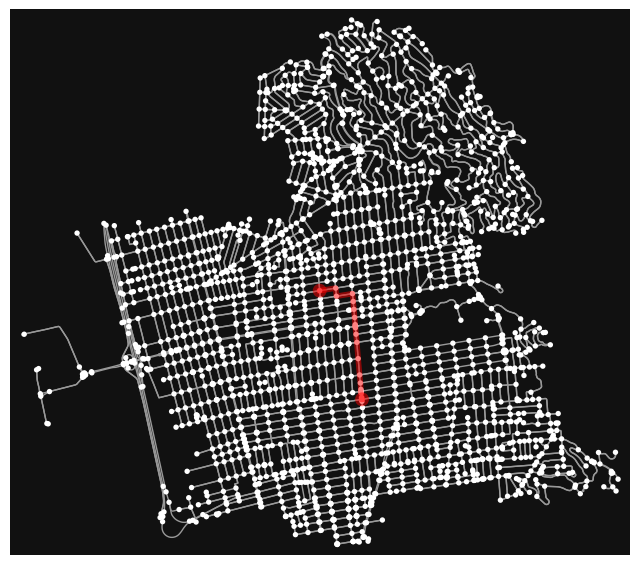

In [13]:
path = dijkstras_search(origin, destination, map_graph)        
fig, ax = ox.plot_graph_route(map_graph, path) 

## A* Search
Next, we will use a distance heuristic to implement A* search for our map search problem. Since we are using real map data here, we will need to convert the data to a format which we can use for distance computation. Each data point has a latitude and longitude associated with it, which we then have to convert into (x, y, z) coordinates on the earth (which we will assume to be a sphere with radius 6371 km). We can then take the straight line distance between these two points as an approximation for the distance between them. Over small distances, this approximation is accurate. This is implemented in the `distance_heuristic()` function below.

In [6]:
# Computes the Euclidean distance between two vertices.
# Assume that the earth is a sphere with radius 6371 km.
def distance_heuristic(state_key, goal_key, node_data):
    n1 = node_data[state_key]
    n2 = node_data[goal_key]

    # Get the longitude and latitude for each vertex.
    long1 = n1['x']*math.pi/180.0
    lat1 = n1['y']*math.pi/180.0
    long2 = n2['x']*math.pi/180.0
    lat2 = n2['y']*math.pi/180.0
    
    # Use a spherical approximation of the earth for
    # estimating the distance between two points.
    r = 6371000
    x1 = r*math.cos(lat1)*math.cos(long1)
    y1 = r*math.cos(lat1)*math.sin(long1)
    z1 = r*math.sin(lat1)

    x2 = r*math.cos(lat2)*math.cos(long2)
    y2 = r*math.cos(lat2)*math.sin(long2)
    z2 = r*math.sin(lat2)

    d = ((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)**0.5
    
    return d

Now, we can use our distance heuristic to perform A* search on our map. As a refresher, we've included the A* pseudocode from Module 3 below.
![A* Pseudocode](a_star.png)
This function will be implemented in the `a_star_search()` function below. As with Dijkstra's search, you should make use of the `get_path()` helper function above. As before, you should find the shortest path from the origin to the goal in the graph, but this time you should use A* with the distance heuristic given above. Good luck!

In [15]:
map_graph.nodes(True)[34351114]

{'y': 37.8661529, 'x': -122.2465302, 'street_count': 1}

In [7]:
# For a given graph, origin vertex key, and goal vertex key,
# computes the shortest path in the graph from the origin vertex
# to the goal vertex using A* search. 
# Returns the shortest path as a list of vertex keys.
def a_star_search(origin_key, goal_key, graph):
    # The priority queue of open vertices we've reached.
    # Keys are the vertex keys, vals are the accumulated
    # distances plus the heuristic estimates of the distance
    # to go.
    open_queue = priority_dict.priority_dict({})
    
    # The dictionary of closed vertices we've processed.
    closed_dict = {}
    
    # The dictionary of predecessors for each vertex.
    predecessors = {}
    
    # The dictionary that stores the best cost to reach each
    # vertex found so far.
    costs = {}
    
    # Get the spatial data for each vertex as a dictionary.
    node_data = graph.nodes(True)
    
    # Add the origin to the open queue and the costs dictionary.
    costs[origin_key] = 0.0
    open_queue[origin_key] = distance_heuristic(origin_key, goal_key, node_data)

    # Iterate through the open queue, until we find the goal.
    # Each time, perform an A* update on the queue.
    # TODO: Implement the A* update loop.
    goal_found = False
    while (open_queue):
        pass
    
    # If we get through entire priority queue without finding the goal,
    # something is wrong.
    if not goal_found:
        raise ValueError("Goal not found in search.")
    
    # Construct the path from the predecessors dictionary.
    return get_path(origin_key, goal_key, predecessors)   

Once this function has been implemented, run the box below to see if your output matches that of the library function at the start of the notebook. If it doesn't, you've made a mistake with your implementation.

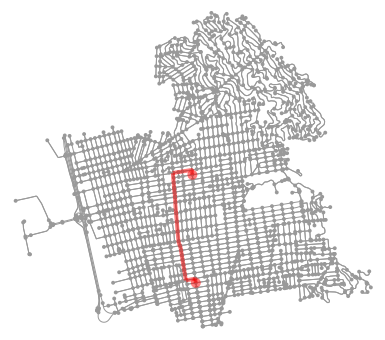

In [8]:
path = a_star_search(origin, destination, map_graph)        
fig, ax = ox.plot_graph_route(map_graph, path) 

Congratulations! You've now implemented two important mission planning algorithms on real map data. 